# Evaluation of RISE, Grad-CAM, RISE-CAM, and RISExCAM
RISE-CAM is an Explainable AI algorithm based on the mechanisms of two classic Explainable AI algorithms--RISE and Grad-CAM.

In this notebook, three algorithms along with RISExCAM (product of RISE and Grad-CAM) will be evaluated using **insertion** and **deletion**.

For the introduction between alrgorithms, please read Introduction_RISECAM.ipynb.

## Preparation

### Import nessasary libraries

In [30]:
import os
import numpy as np
from matplotlib import pyplot as plt
from PIL import Image
import json

import torch
import torch.nn as nn
import torch.backends.cudnn as cudnn
from torchvision import transforms
import torchvision.models as models

cudnn.benchmark = True
torch.cuda.get_device_name()

'NVIDIA GeForce RTX 2080 Ti'

### Define or import functions

In [31]:
from algorithms import rise, gradcam, risecam, get_class_name, tensor_imshow, blur, auc, CausalMetric

# Set the size of the input image.
input_size = (224, 224)

# Function that opens image from disk, normalizes it and converts to tensor
read_tensor = transforms.Compose([
    lambda x: Image.open(x),
    transforms.Resize(input_size),
    transforms.ToTensor(),
    transforms.Normalize(
        mean=[0.485, 0.456, 0.406],
        std=[0.229, 0.224, 0.225]
    ),
    lambda x: torch.unsqueeze(x, 0)
])

# Image preprocessing function
preprocess = transforms.Compose([
    transforms.Resize(input_size),
    transforms.ToTensor(),
    # Normalization for ImageNet
    transforms.Normalize(
        mean=[0.485, 0.456, 0.406],
        std=[0.229, 0.224, 0.225]
    ),
])

input_tensor = read_tensor('examples/antelope.jpg')

### Load black-box model

In [32]:
# Load black box model for explanations
model = models.resnet50(True)
model = nn.Sequential(model, nn.Softmax(dim=1))
model = model.eval()
model = model.cuda()

for p in model.parameters():
    p.requires_grad = False

## Preparing substrate functions

For our causal metrics we need functions that define how we delete/insert pixels. Specifically, we define mapping from old pixels to new pixels. We use zero substrate for deletion and blurred image substrate for insertion.

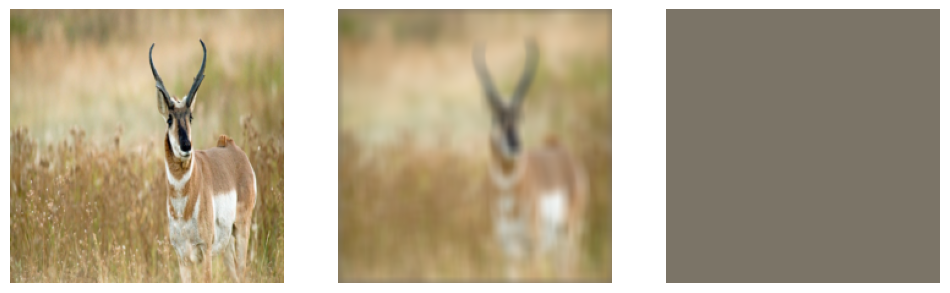

In [33]:
plt.figure(figsize=(12, 4))
plt.subplot(131)
plt.axis('off')
tensor_imshow(input_tensor[0])

plt.subplot(132)
plt.axis('off')
tensor_imshow(blur(input_tensor, klen=11, nsig=5)[0])

plt.subplot(133)
plt.axis('off')
tensor_imshow(torch.zeros_like(input_tensor)[0])

plt.show()

## Obtain the saliency maps of the algorithms
Obtain the saliency maps from RISE, Grad-CAM, RISE-CAM, and RISExCAM for the later evaluation.

In [34]:
# Get the predicted class.
probabilities, classes = torch.topk(model(input_tensor.cuda()), k=1)
probabilities, classes = probabilities[0], classes[0]
probabilities.item(), classes.item()

(0.7716467976570129, 353)

Loading masks.


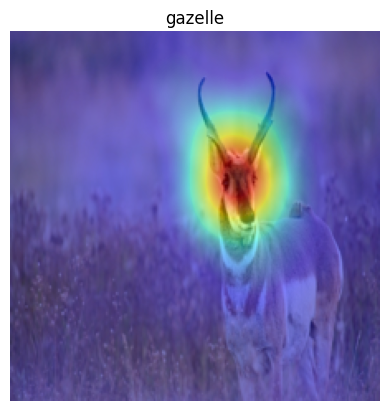

In [35]:
# Get and show the saliency map of RISE.
rise_sal = rise(model, input_tensor, input_size=input_size, mask_path='masks_6000.npy')

tensor_imshow(input_tensor[0])
plt.axis('off')
plt.title(get_class_name(classes))
plt.imshow(rise_sal, cmap='jet', alpha=0.5)
plt.show()

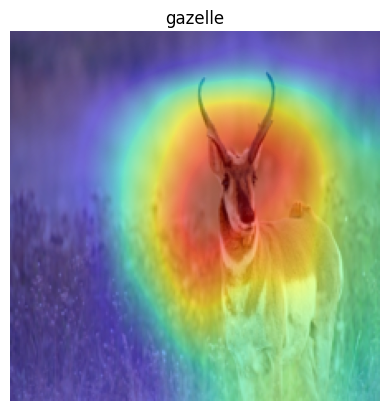

In [36]:
# Get and show the saliency map of Grad-CAM.
gradcam_sal = gradcam(model, input_tensor, input_size=input_size)

tensor_imshow(input_tensor[0])
plt.axis('off')
plt.title(get_class_name(classes))
plt.imshow(gradcam_sal, cmap='jet', alpha=0.5)
plt.show()

100%|██████████| 100/100 [00:09<00:00, 10.56it/s]


best value for k is: 1


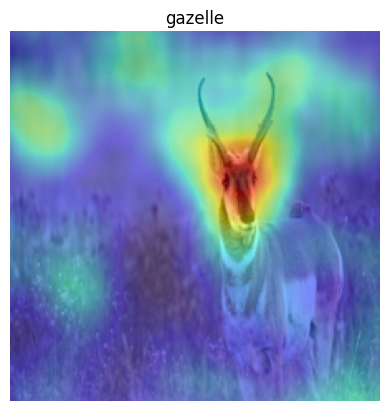

In [37]:
# Get and show the saliency map of RISE-CAM.
risecam_sal = risecam(model, input_tensor, input_size=input_size, mask_path='masks_100.npy', top_k='optimal')

tensor_imshow(input_tensor[0])
plt.axis('off')
plt.title(get_class_name(classes))
plt.imshow(risecam_sal, cmap='jet', alpha=0.5)
plt.show()

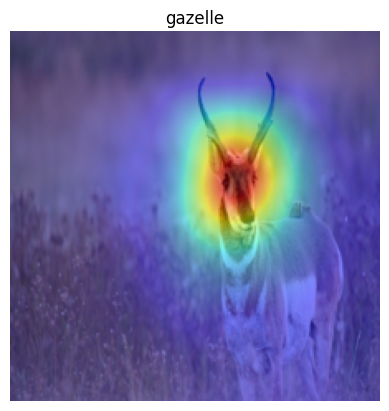

In [38]:
# Get and show the saliency map of RISExCAM.
risexcam_sal = np.multiply(rise_sal, gradcam_sal)

tensor_imshow(input_tensor[0])
plt.axis('off')
plt.title(get_class_name(classes))
plt.imshow(risexcam_sal, cmap='jet', alpha=0.5)
plt.show()

## Evaluating metrics: insertion and deletion
For insertion, pixels will be gradually added to the image in the sequence of their importance given by the saliency map, and the change in confidence will be tracked when fed into the model. The score will be the area under the curve. The higher the score is, the better the saliency map is.

Deletion, on the other hand, deletes the pixels and tracks the drop in confidence. Opposite to insertion, an accurate saliency map will have a low deletion score.

In [39]:
insertion = CausalMetric(model, 'ins', input_size[0], substrate_fn=blur)
deletion = CausalMetric(model, 'del', input_size[0], substrate_fn=torch.zeros_like)

The starting image in the **insertion** process is an blurred image. This is because the input pixels will usually form an oval resulting in the misclassification of the model (might classify it as a ballon or other oval shape objects).

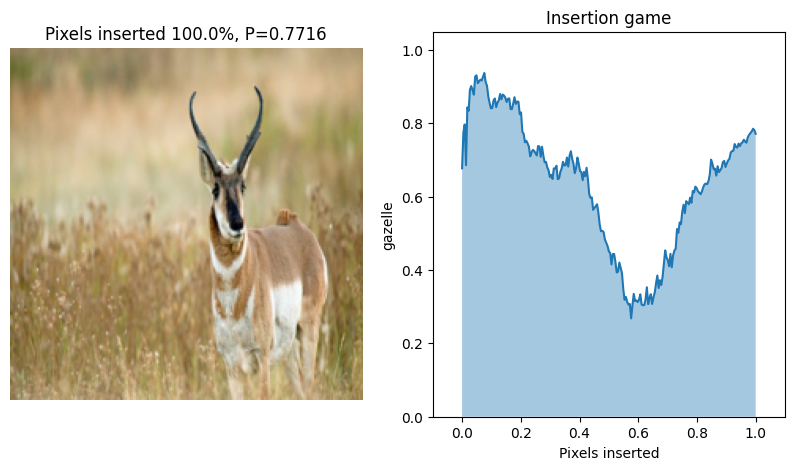

In [40]:
insertion_scores = insertion.single_run(input_tensor, risecam_sal, input_size[0]*input_size[1], verbose=1)

The final image in the **deletion** process is an all-zero image. It is gray instead of black, because we are setting pixels to $0$ in the space of normalized images. Deletion does not encounter the shape problem in the insertion, so the deleted pixels will be set to zero.

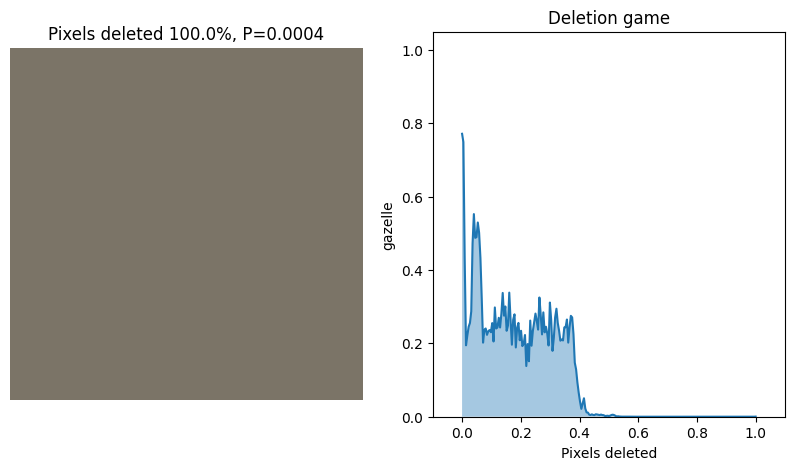

In [27]:
deletion_scores = deletion.single_run(input_tensor, risecam_sal, input_size[0]*input_size[1], verbose=1)

## Comparison between RISE, Grad-CAM, RISE-CAM, and RISExCAM
Demonstrate the comparison between RISE, Grad-CAM, RISE-CAM, and RISExCAM on the saliency maps, insertion, and deletion. Most images encountered a confidence drop after the peak in the 0% to 20% range (see the curve in the previous session). At the same time, the confidence of deletion was insignificant after the same range of around 20%. Consequently, there will be five scores shown: insertion, deletion, top 20% insertion (area under the top 20% insertion curve), top 20% deletion (area under the top 20% deletion curve), and **top 20% insertion - top 20% deletion**.

In [41]:
# Show the image with overlays and the scores of each algorithms. This function will return the scores.
def show_comparison(saliencies, img, names=[], verbose=True):
    if verbose:
        plt.figure(figsize=(20, 5))
        
        plt.subplot(151)
        plt.axis('off')
        p, c = torch.topk(model(img.cuda()), 1)
        plt.title('{}: {:.1f}%'.format(get_class_name(c), 100 * float(p)))
        tensor_imshow(img[0])

    scores = np.zeros((len(saliencies), 5))

    if(len(names) != len(saliencies)):
        names = ['algorithm {}'.format(i) for i in range(len(saliencies))]

    for i, saliency in enumerate(saliencies):
        deletion_sal = deletion.single_run(img, saliency, input_size[0]*input_size[1])
        scores[i][0] = auc(deletion_sal)
        scores[i][1] = auc(deletion_sal, fraction=0.2)
        insertion_sal = insertion.single_run(img, saliency, input_size[0]*input_size[1])
        scores[i][2] = auc(insertion_sal)
        scores[i][3] = auc(insertion_sal, fraction=0.2)
        scores[i][4] = scores[i][3] - scores[i][1]

        if verbose:
            plt.subplot(152+i)
            plt.axis('off')
            tensor_imshow(img[0])
            plt.imshow(saliency, alpha=0.5, cmap='jet')
            plt.title('{}: {:.3f} / {:.3f} / {:.3f} / {:.3f} / {:.3f}'.format(
                names[i],
                scores[i][0],
                scores[i][1],
                scores[i][2],
                scores[i][3],
                scores[i][4]
            ), fontsize=9)
    
    if verbose:
        plt.show()

    return scores

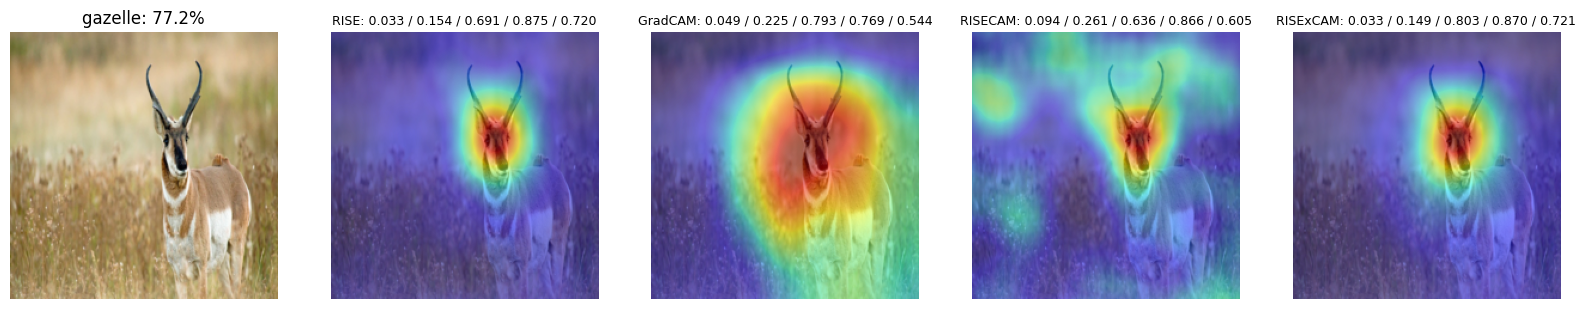

In [42]:
# Input the previously generate the saliency maps, show the explanation, and compute the scores.
scores = show_comparison(
    [rise_sal, gradcam_sal, risecam_sal, risexcam_sal],
    input_tensor,
    names=['RISE', 'GradCAM', 'RISECAM', 'RISExCAM']
)